In [1]:
# Importing Dependencies

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy as np
import pandas as pd
import glob
import xarray as xr
import warnings
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import rioxarray
from rasterio import features
from affine import Affine

In [4]:
# 1 Loading AOD Dataset for testing 
aod_file = glob.glob('./Data/AOD/*')
aod_insat3D = glob.glob(aod_file[0]+'/*')
aod_insat3DR = glob.glob(aod_file[1]+'/*')
ds_3DR = xr.open_mfdataset(aod_insat3DR)
ds_3D = xr.open_mfdataset(aod_insat3D)

#slicing
ds1_3DR = ds_3DR.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99)).load()
ds1_3D = ds_3D.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99)).load()



In [5]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

In [6]:
def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))


In [7]:
def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [8]:
# 2 - Shape file dir
sf_dir = './Data/India_Boundary/India_Boundary.shp'

ds_3D_mask = add_shape_coord_from_data_array(ds1_3D, sf_dir, "MASK")
ds2_3D = ds_3D_mask.where(ds_3D_mask.MASK==0, other=np.nan)
ds2_3D = ds2_3D.drop_vars('MASK')

ds_3DR_mask = add_shape_coord_from_data_array(ds1_3DR, sf_dir, "MASK")
ds2_3DR = ds_3DR_mask.where(ds_3DR_mask.MASK==0, other=np.nan)
ds2_3DR = ds2_3DR.drop_vars('MASK')

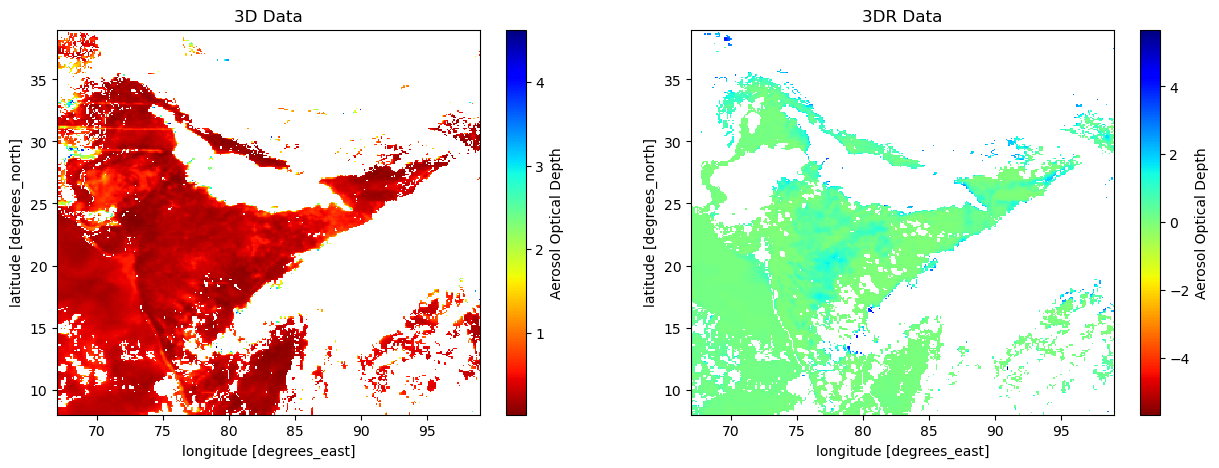

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ds1_3D.AOD.isel(time=0).plot(ax=ax[0],cmap = 'jet_r')
ax[0].set_title('3D Data')
ds1_3DR.AOD.isel(time=0).plot(ax=ax[1],cmap = 'jet_r')
ax[1].set_title('3DR Data')
plt.show()

# NaN values in Datasets

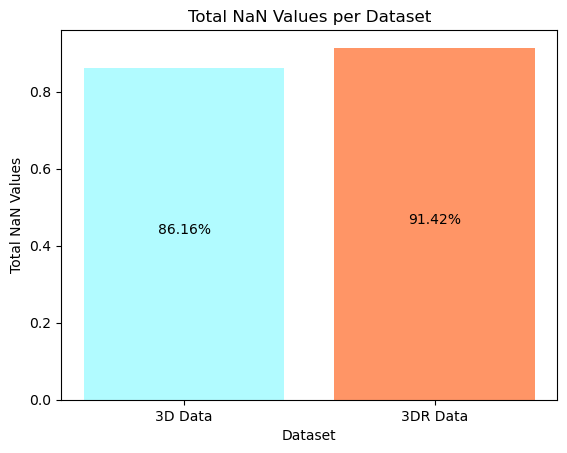

In [10]:
nan_3dr = ds2_3DR.AOD.isnull().sum().values
nan_3d = ds2_3D.AOD.isnull().sum().values

t,m,n = ds2_3DR.AOD.data.shape
tot = t*m*n
nan_3dr = nan_3dr/tot

t,m,n = ds2_3D.AOD.data.shape
tot = t*m*n
nan_3d = nan_3d/tot

NaN_data = {'3D Data':nan_3d , '3DR Data': nan_3dr}


# PLot
fig, ax = plt.subplots()
bars = ax.bar(NaN_data.keys(), NaN_data.values(), color=['#7DF9FF', '#FF4F00'],alpha=0.6)

# Annotations
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(list(NaN_data.values())[i]*100,2)}%', ha='center')

# Labels and Title
plt.xlabel('Dataset')
plt.ylabel('Total NaN Values')
plt.title('Total NaN Values per Dataset')
plt.savefig('plots/aod_plot/Total_Nan.png')
plt.show()


In [11]:
ds2_3DR.AOD.min().values,ds2_3D.AOD.min().values

(array(-0.05990245), array(0.))

In [12]:
# 3 - Filter out negative data 
ds3_3DR = ds2_3DR.where(ds2_3DR.AOD > 0)

ds3_3D = ds2_3D.where(ds2_3D.AOD > 0)

In [13]:
ds3_3DR.AOD.min().values,ds3_3D.AOD.min().values

(array(2.88638322e-08), array(3.42646473e-07))

In [14]:
# 4 - 1D mean
ds4_3DR = ds3_3DR.resample(time = "1D").mean()
ds4_3DR = ds4_3DR[['time','latitude','longitude','AOD']]

ds4_3D = ds3_3D.resample(time = "1D").mean()
ds4_3D = ds4_3D[['time','latitude','longitude','AOD']]


In [15]:
ds4_3DR.AOD.max().values,ds4_3D.AOD.max().values

(array(6.70053673), array(4.99216795))

## Plots to compare both dataset

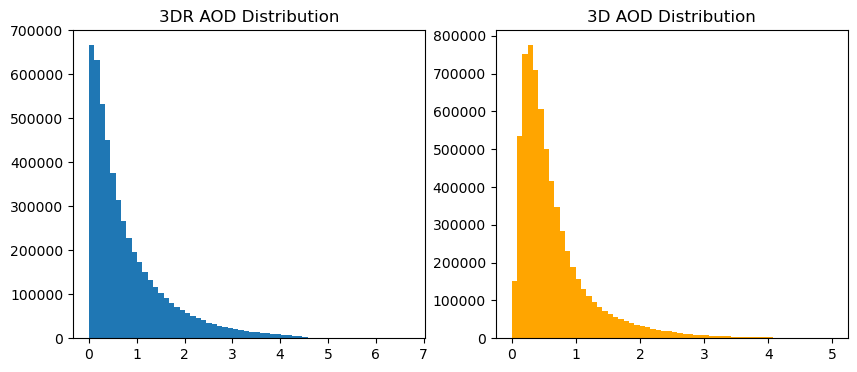

In [16]:

data1_aod = ds4_3DR['AOD'].to_dataframe()['AOD']
data2_aod = ds4_3D['AOD'].to_dataframe()['AOD']

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(data1_aod, bins=60)
axs[0].set_title('3DR AOD Distribution')
axs[1].hist(data2_aod, bins=60,color='orange')
axs[1].set_title('3D AOD Distribution')
plt.show()

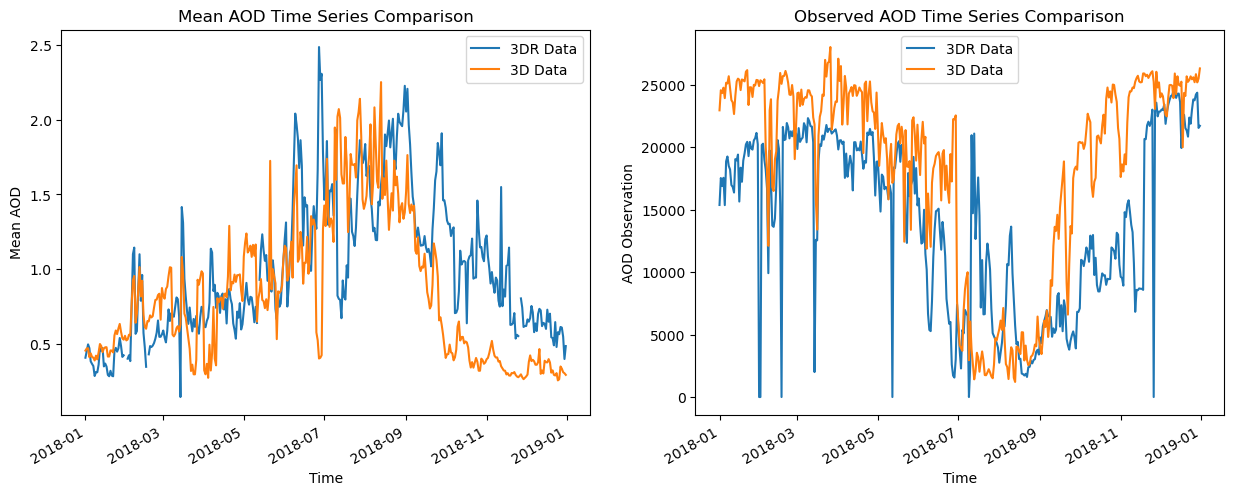

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

data1_mean = ds4_3DR['AOD'].mean(dim=('latitude', 'longitude'))
data2_mean = ds4_3D['AOD'].mean(dim=('latitude', 'longitude'))
data1_mean.plot.line(ax=ax[0], label='3DR Data')
data2_mean.plot.line(ax=ax[0], label='3D Data')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Mean AOD')
ax[0].set_title('Mean AOD Time Series Comparison')

# Total data point available at every time stamp
data1_count = ds4_3DR['AOD'].count(dim=('latitude', 'longitude'))
data2_count = ds4_3D['AOD'].count(dim=('latitude', 'longitude'))
data1_count.plot.line(ax=ax[1], label='3DR Data')
data2_count.plot.line(ax=ax[1], label='3D Data')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('AOD Observation')
ax[1].set_title('Observed AOD Time Series Comparison')

plt.savefig("./plots/aod_plot/3Dv3DR_timeserie")
plt.show()

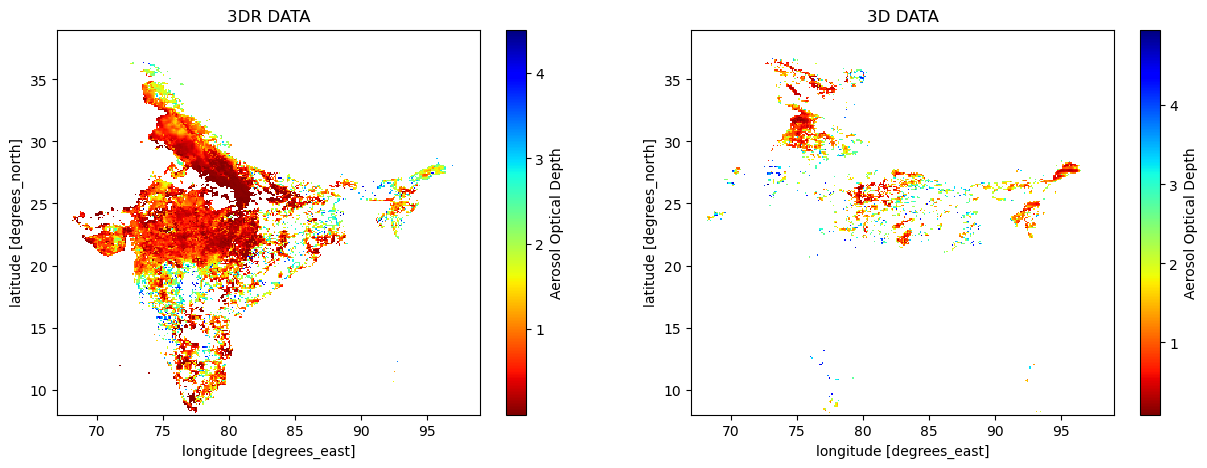

In [18]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ds4_3DR.AOD.sel(time='2018-07-15').plot(ax=ax[0],cmap = 'jet_r')
ax[0].set_title("3DR DATA")

ds4_3D.AOD.sel(time='2018-07-15').plot(ax=ax[1],cmap = 'jet_r',label='Data1')
ax[1].set_title("3D DATA")

plt.show()

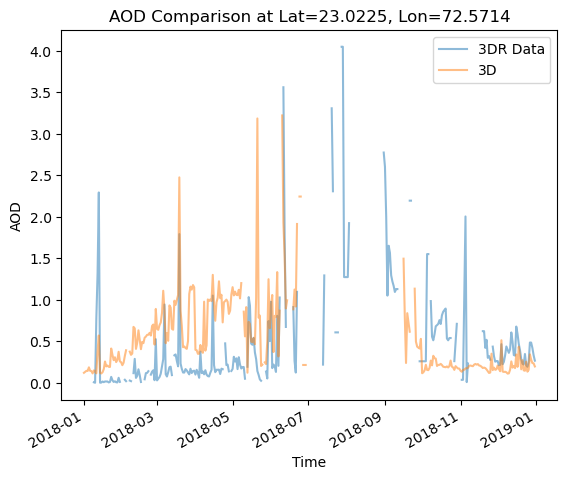

In [19]:
lat = 23.0225
lon = 72.5714

# Select the AOD values at the given lat-lon coordinate for each dataset
data1_aod = ds4_3DR['AOD'].sel(latitude=lat, longitude=lon,method='nearest')
data2_aod = ds4_3D['AOD'].sel(latitude=lat, longitude=lon,method='nearest')

# Create a line plot of the AOD values for each dataset
fig, ax = plt.subplots()
data1_aod.plot.line(ax=ax, label='3DR Data', alpha=0.5)
data2_aod.plot.line(ax=ax, label='3D', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('AOD')
plt.title(f'AOD Comparison at Lat={lat}, Lon={lon}')
plt.legend()
plt.show()